In [2]:
import sys
from dotenv import load_dotenv
import os

load_dotenv()

sys.path.append(os.getenv("ROOT"))

In [3]:
import polars as pl
import numpy as np
from datetime import date
from silverfund.datasets.crsp_daily import CRSPDaily
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Load dataset
df = (
    CRSPDaily(start_date=date(1995, 7, 31), end_date=date(2024, 12, 31))
    .load_all()
    .select(["permno", "ticker", "date", "shrout", "prc", "ret"])
)

df

Loading CRSP Daily years:   0%|          | 0/30 [00:00<?, ?it/s]

Loading CRSP Daily years: 100%|██████████| 30/30 [00:02<00:00, 14.53it/s]


permno,ticker,date,shrout,prc,ret
i64,str,date,f64,f64,f64
10001,"""EWST""",1995-07-31,2254.0,8.25,0.03125
10001,"""EWST""",1995-08-01,2254.0,-8.125,-0.015152
10001,"""EWST""",1995-08-02,2254.0,8.25,0.015385
10001,"""EWST""",1995-08-03,2254.0,7.75,-0.060606
10001,"""EWST""",1995-08-04,2254.0,8.25,0.064516
…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063


In [5]:
# Form momentum signal

# Log returns
df = df.with_columns(pl.col("ret").log1p().alias("logret"))

# Rolling sum from t-252 to t-22
df = df.with_columns(
    pl.col("logret").rolling_sum(window_size=230, min_periods=230).over("permno").alias("mom")
)

# Lag
df = df.with_columns(pl.col("mom").shift(22).over("permno"))

df

permno,ticker,date,shrout,prc,ret,logret,mom
i64,str,date,f64,f64,f64,f64,f64
10001,"""EWST""",1995-07-31,2254.0,8.25,0.03125,0.030772,null
10001,"""EWST""",1995-08-01,2254.0,-8.125,-0.015152,-0.015268,null
10001,"""EWST""",1995-08-02,2254.0,8.25,0.015385,0.015268,null
10001,"""EWST""",1995-08-03,2254.0,7.75,-0.060606,-0.06252,null
10001,"""EWST""",1995-08-04,2254.0,8.25,0.064516,0.06252,null
…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,-0.091874
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.101033
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.131252


In [6]:
# Filters

# Price greater than 5
df = df.with_columns(pl.col("prc").shift(1).over("permno").alias("prclag"))
df = df.filter(pl.col("prclag") > 5)

# Non-null momentum signal
df = df.drop_nulls(subset=["mom"])

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag
i64,str,date,f64,f64,f64,f64,f64,f64
10001,"""EWST""",1996-07-26,2321.0,8.125,0.0,0.0,0.076755,8.125
10001,"""EWST""",1996-07-29,2321.0,-8.1875,0.007692,0.007663,0.045983,8.125
10001,"""EWST""",1996-07-31,2321.0,-8.1875,-0.022388,-0.022642,0.015212,8.375
10001,"""EWST""",1996-08-02,2321.0,8.25,0.03125,0.030772,0.045983,8.0
10001,"""EWST""",1996-08-05,2321.0,8.0,-0.030303,-0.030772,0.015212,8.25
…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,-0.091874,339.64001
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.101033,352.56
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.131252,338.59


In [7]:
# Create portfolio bins

labels = [str(x) for x in range(10)]

df = df.with_columns(pl.col("mom").qcut(10, labels=labels).over("date").alias("bin"))

df

permno,ticker,date,shrout,prc,ret,logret,mom,prclag,bin
i64,str,date,f64,f64,f64,f64,f64,f64,cat
10001,"""EWST""",1996-07-26,2321.0,8.125,0.0,0.0,0.076755,8.125,"""3"""
10001,"""EWST""",1996-07-29,2321.0,-8.1875,0.007692,0.007663,0.045983,8.125,"""3"""
10001,"""EWST""",1996-07-31,2321.0,-8.1875,-0.022388,-0.022642,0.015212,8.375,"""2"""
10001,"""EWST""",1996-08-02,2321.0,8.25,0.03125,0.030772,0.045983,8.0,"""3"""
10001,"""EWST""",1996-08-05,2321.0,8.0,-0.030303,-0.030772,0.015212,8.25,"""2"""
…,…,…,…,…,…,…,…,…,…
93436,"""TSLA""",2024-11-22,3.207e6,352.56,0.03804,0.037334,-0.091874,339.64001,"""1"""
93436,"""TSLA""",2024-11-25,3.207e6,338.59,-0.039625,-0.040431,0.101033,352.56,"""3"""
93436,"""TSLA""",2024-11-26,3.207e6,338.23001,-0.001063,-0.001064,0.131252,338.59,"""4"""


In [8]:
# Create portfolio returns dataframe

# Aggregate (equal weight portfolios)
port = df.group_by(["date", "bin"]).agg(pl.col("ret").mean())

# Pivot
port = port.pivot(on="bin", index="date", values="ret")

# Reorder columns
port = port.select(["date"] + labels)

# Sort
port = port.sort(by="date")

port

date,0,1,2,3,4,5,6,7,8,9
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-07-26,0.019594,0.010926,0.006394,0.008605,0.005703,0.005099,0.007221,0.010894,0.010641,0.018184
1996-07-29,-0.003989,-0.005179,-0.004139,-0.00554,-0.00177,-0.004969,-0.001992,-0.002653,-0.005731,-0.009017
1996-07-30,0.00161,0.002102,0.001516,0.00238,0.001839,0.004484,0.001446,0.002978,-0.001721,-0.002253
1996-07-31,0.010159,0.011069,0.005236,0.005952,0.004659,0.005194,0.006861,0.00962,0.00556,0.013806
1996-08-01,0.007998,0.009217,0.007876,0.007316,0.009731,0.009663,0.006964,0.009833,0.01115,0.013832
…,…,…,…,…,…,…,…,…,…,…
2024-11-22,0.023205,0.016301,0.018135,0.01318,0.01773,0.013064,0.0141405,0.015726,0.018736,0.025977
2024-11-25,0.027911,0.023247,0.019259,0.011536,0.012539,0.011448,0.010822,0.011343,0.011928,0.00751
2024-11-26,-0.015452,-0.011073,-0.010122,-0.005646,-0.005556,-0.004389,-0.003927,-0.001202,-0.001078,0.000021


In [9]:
# Create spread portfolio

port = port.with_columns((pl.col("9") - pl.col("0")).alias("spread"))

port

date,0,1,2,3,4,5,6,7,8,9,spread
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
1996-07-26,0.019594,0.010926,0.006394,0.008605,0.005703,0.005099,0.007221,0.010894,0.010641,0.018184,-0.00141
1996-07-29,-0.003989,-0.005179,-0.004139,-0.00554,-0.00177,-0.004969,-0.001992,-0.002653,-0.005731,-0.009017,-0.005027
1996-07-30,0.00161,0.002102,0.001516,0.00238,0.001839,0.004484,0.001446,0.002978,-0.001721,-0.002253,-0.003863
1996-07-31,0.010159,0.011069,0.005236,0.005952,0.004659,0.005194,0.006861,0.00962,0.00556,0.013806,0.003647
1996-08-01,0.007998,0.009217,0.007876,0.007316,0.009731,0.009663,0.006964,0.009833,0.01115,0.013832,0.005835
…,…,…,…,…,…,…,…,…,…,…,…
2024-11-22,0.023205,0.016301,0.018135,0.01318,0.01773,0.013064,0.0141405,0.015726,0.018736,0.025977,0.002772
2024-11-25,0.027911,0.023247,0.019259,0.011536,0.012539,0.011448,0.010822,0.011343,0.011928,0.00751,-0.020401
2024-11-26,-0.015452,-0.011073,-0.010122,-0.005646,-0.005556,-0.004389,-0.003927,-0.001202,-0.001078,0.000021,0.015472


In [10]:
# Unpivot dataframe
port = port.unpivot(index="date", variable_name="bin", value_name="ret")

# Sort
port = port.sort(by=["date", "bin"])

port

date,bin,ret
date,str,f64
1996-07-26,"""0""",0.019594
1996-07-26,"""1""",0.010926
1996-07-26,"""2""",0.006394
1996-07-26,"""3""",0.008605
1996-07-26,"""4""",0.005703
…,…,…
2024-11-29,"""6""",0.003587
2024-11-29,"""7""",0.003132
2024-11-29,"""8""",0.001676


In [11]:
# Calculate mean, std, sharpe, and tstat of each portfolio

# Mean, std, and count
result = port.group_by("bin").agg(
    [
        pl.col("ret").mean().cast(pl.Float64).alias("mean"),
        pl.col("ret").std().cast(pl.Float64).alias("std"),
        pl.col("ret").count().cast(pl.Float64).alias("count"),
    ]
)

# Sharpe
result = result.with_columns(
    ((pl.col("mean") * 252) / (pl.col("std") * np.sqrt(252)))
    .cast(pl.Float64)
    .alias("annualized_sharpe")
)

# Tstat
result = result.with_columns(
    (pl.col("mean") / (pl.col("std") / pl.col("count").sqrt())).cast(pl.Float64).alias("tstat")
)

# Sort
result = result.sort(by="bin")

# Transpose
result = result.transpose(include_header=True, column_names="bin", header_name="statistic")

print("Daily results")
result

Daily results


statistic,0,1,2,3,4,5,6,7,8,9,spread
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.000153,0.000442,0.000557,0.000589,0.000641,0.000665,0.000635,0.000702,0.000714,0.000754,0.000601
"""std""",0.018547,0.014727,0.013153,0.01222,0.011618,0.011273,0.011171,0.011601,0.012764,0.016201,0.013627
"""count""",7135.0,7135.0,7135.0,7135.0,7135.0,7135.0,7135.0,7135.0,7135.0,7135.0,7135.0
"""annualized_sharpe""",0.130621,0.476911,0.671886,0.765217,0.875229,0.935796,0.902203,0.960396,0.888533,0.738814,0.700582
"""tstat""",0.695039,2.537664,3.575136,4.071754,4.65713,4.979413,4.800658,5.110307,4.72792,3.931262,3.727824


In [12]:
# Create backtest plot

# Log returns
port = port.with_columns(pl.col("ret").log1p().over("bin").alias("logret"))

# Cummulative sum log returns
port = port.with_columns(pl.col("logret").cum_sum().over("bin").alias("cumret") * 100)

port

date,bin,ret,logret,cumret
date,str,f64,f64,f64
1996-07-26,"""0""",0.019594,0.019404,1.940431
1996-07-26,"""1""",0.010926,0.010867,1.086684
1996-07-26,"""2""",0.006394,0.006374,0.637373
1996-07-26,"""3""",0.008605,0.008568,0.856792
1996-07-26,"""4""",0.005703,0.005686,0.568641
…,…,…,…,…
2024-11-29,"""6""",0.003587,0.003581,408.162965
2024-11-29,"""7""",0.003132,0.003127,452.407541
2024-11-29,"""8""",0.001676,0.001674,451.151405


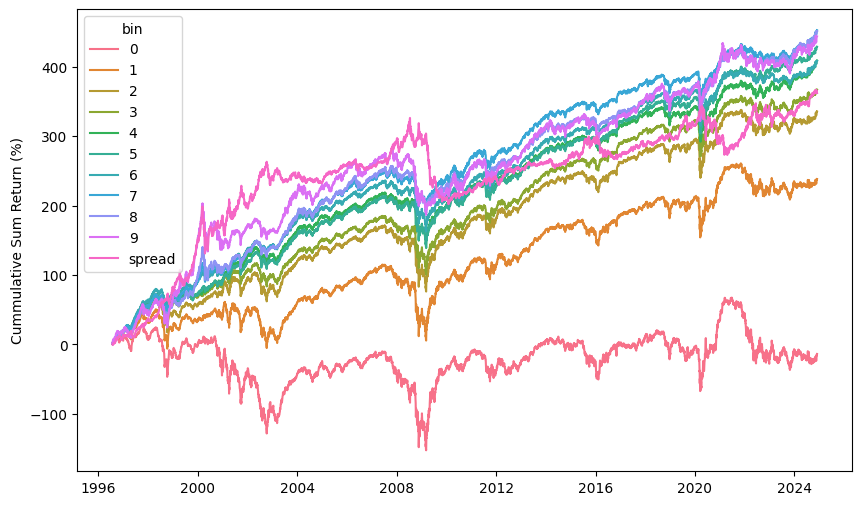

In [13]:
plt.figure(figsize=(10, 6))
sns.lineplot(port, x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

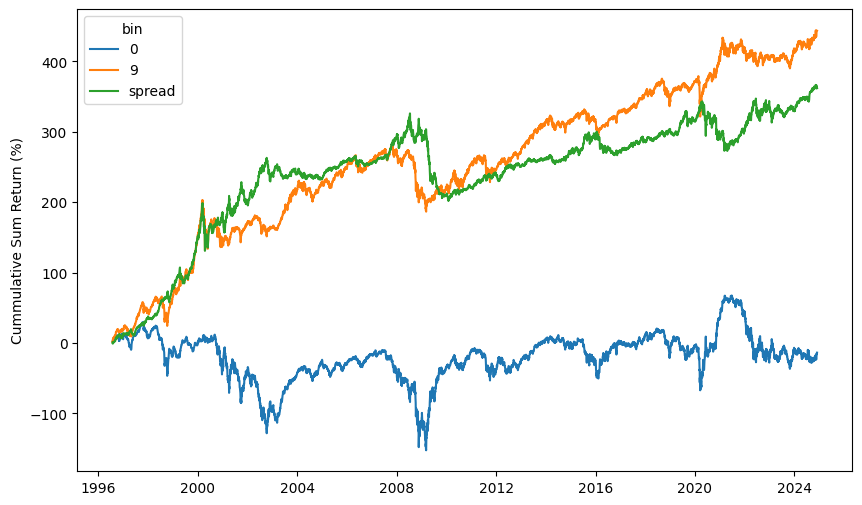

In [14]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    port.filter(pl.col("bin").is_in(["0", "9", "spread"])), x="date", y="cumret", hue="bin"
)
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

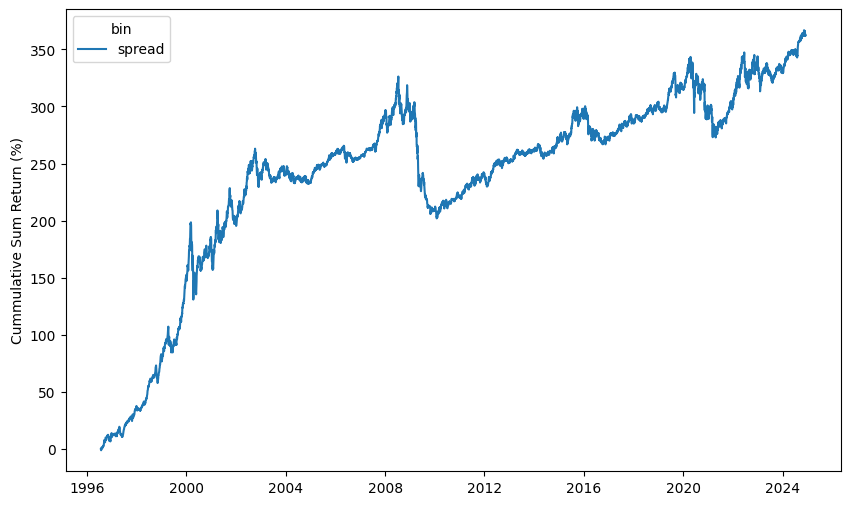

In [15]:
plt.figure(figsize=(10, 6))
sns.lineplot(port.filter(pl.col("bin") == "spread"), x="date", y="cumret", hue="bin")
plt.xlabel(None)
plt.ylabel("Cummulative Sum Return (%)")
plt.show()

In [16]:
min_date = port["date"].min().strftime("%Y-%m-%d")
max_date = port["date"].max().strftime("%Y-%m-%d")

print(f"From {min_date} to {max_date}")

From 1996-07-26 to 2024-11-29
